# SD 201 - Mining of Large Datasets
Daniel Vahos and Lucas Sousa


In [304]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.io
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
import re


We got data from a [dataset](https://www.kaggle.com/etiennelq/french-employment-by-town) uploaded to Kaggle by Étienne LQ which contains information on number and size of companies, average salary in different categories, geographic information and demographics per French town, a [table](https://crimes.politologue.com/departements/) from Politologue.com containing information on total number of crimes per French department per year, and some data directly from the Insee website: [“Structure et distribution des revenus, inégalité des niveaux de vie en 2015”](https://www.insee.fr/fr/statistiques/3560118) (Structure and distribution of incomes, inequalities and standards of living in 2015) and “[Populations légales 2015](https://www.insee.fr/fr/statistiques/3545833?sommaire=3292701)” (Legal population 2015).

In [305]:
!rm -r ./sample_data 
!rm ./*
!git clone https://github.com/lucasomsousa/SD201---Final-Project.git
!mv ./SD201---Final-Project/* ./
!rm -r ./SD201---Final-Project/
!unzip unemploymentData.zip
!rm ./unemploymentData.zip


rm: cannot remove './sample_data': No such file or directory
Cloning into 'SD201---Final-Project'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 12 (delta 2), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.
Archive:  unemploymentData.zip
  inflating: base_etablissement_par_tranche_effectif.csv  
  inflating: communes.geojson        
  inflating: departements.geojson    
  inflating: name_geographic_information.csv  
  inflating: net_salary_per_town_categories.csv  
  inflating: population.csv          


In [306]:
population = pd.read_csv("./population.csv");
netSalary = pd.read_csv("./net_salary_per_town_categories.csv")
geographicInfo = pd.read_csv("./name_geographic_information.csv")
establishments = pd.read_csv("./base_etablissement_par_tranche_effectif.csv")

population["CODGEO"] = population["CODGEO"].astype('string');
netSalary["CODGEO"] = netSalary["CODGEO"].astype('string');
establishments["CODGEO"] = establishments["CODGEO"].astype('string');

departmentByCodgeo = geographicInfo[['numéro_département', 'code_insee']];
departmentByCodgeo.rename(columns={"numéro_département": "DEP", "code_insee": "CODGEO"}, inplace=True);
departmentByCodgeo["CODGEO"] = departmentByCodgeo["CODGEO"].astype('string');
departmentByCodgeo.drop_duplicates(inplace=True)

regionByDepartment = geographicInfo[['code_région', 'numéro_département']];
regionByDepartment.rename(columns={"numéro_département": "Department", "code_région": "Region"}, inplace=True);
regionByDepartment.drop_duplicates(inplace=True)

coordinatesByDepartment = geographicInfo[['numéro_département', 'latitude', 'longitude']]
coordinatesByDepartment[coordinatesByDepartment['longitude'] == '-'] = pd.NA
coordinatesByDepartment.dropna(inplace=True)

coordinatesByDepartment['longitude'] = coordinatesByDepartment['longitude'].astype('float64')
coordinatesByDepartment['latitude'] = coordinatesByDepartment['latitude'].astype('float64')
coordinatesByDepartment = coordinatesByDepartment.groupby('numéro_département', as_index=False).mean()

coordinatesByDepartment.rename(columns={"numéro_département": "Department", "latitude": "Latitude", "longitude": "Longitude"}, inplace=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: Se

We got the crime data for the years of 2012-2019 from the website https://crimes.politologue.com/departements/. The table provided isn't very clean, so we used a little *jQuery* code to get the data from the table and convert it into a csv-friendly format. Also, the name of the departments and their respective codes are both in the same string, so we use regular expressions below to split the department name and code into two different colums.


In [307]:
df=pd.read_csv('./Crimes France.csv')
regions = df["Region"]
regionNames = []
regionCodes = []

regexAlphabet = re.compile('[0-9()]')
regexNumbers = re.compile('[^0-9]')

for region in regions:
  regionNames.append(regexAlphabet.sub('', region))
  regionCodes.append(regexNumbers.sub('', region))

df["Region"] = regionNames
df.rename(columns={"Region": "Department Name"}, inplace=True)
df.insert(1, "Department", regionCodes)

df.head()

,Department Name,Department,2019,Var,2018,Var.1,2017,Var.2,2016,Var.3,2015,Var.4,2014,Var.5,2013,Var.6,2012
0,Ain,01,27173,+4.16%,26087,+5.46%,24736,+0.95%,24503,-4.88%,25761,+4.70%,24605,+6.35%,23135,+4.00%,22246
1,Aisne,02,26234,+1.52%,25842,+10.43%,23402,+4.24%,22450,-4.33%,23465,+0.67%,23309,-4.40%,24382,-0.36%,24469
2,Allier,03,14036,+4.62%,13416,+0.21%,13388,+4.79%,12776,+4.88%,12181,+0.26%,12149,-7.27%,13101,+11.40%,11760
3,Alpes-de-Haute-Provence,04,8631,+3.16%,8367,+1.36%,8255,-0.83%,8324,+4.10%,7996,+3.37%,7735,+4.51%,7401,-3.80%,7693
4,Alpes-Maritimes,06,73427,+2.40%,71708,+1.19%,70865,-1.96%,72281,-10.20%,80490,-0.17%,80627,-2.86%,82997,-5.20%,87550


Here we merge the net salary table with the establishments table to get salary informations by department, and then we calculate the mean salary for the four types of salaried people provided in the database (Executives, Managers, Employees and Workers).

In [308]:
salariesAndDepartments = pd.merge(netSalary, establishments[["DEP", "CODGEO"]], on="CODGEO")
meanSalariesPerDepartment = salariesAndDepartments.groupby(by='DEP', as_index=False).mean()

In [309]:
averageSalaries = pd.DataFrame()

averageSalaries.insert(0, 'Department', np.unique(meanSalariesPerDepartment['DEP']))
averageSalaries.insert(1, 'Executive Salary', meanSalariesPerDepartment['SNHMC14'])
averageSalaries.insert(2, 'Manager Salary', meanSalariesPerDepartment['SNHMP14'])
averageSalaries.insert(3, 'Employee Salary', meanSalariesPerDepartment['SNHME14'])
averageSalaries.insert(4, 'Worker Salary', meanSalariesPerDepartment['SNHMO14'])

averageSalaries.head()

,Department,Executive Salary,Manager Salary,Employee Salary,Worker Salary
0,01,24.377465,14.554930,10.719718,11.294366
1,02,22.729412,14.126471,10.079412,10.911765
2,03,22.655556,13.870370,10.000000,10.774074
3,04,23.040000,14.173333,10.153333,10.873333
4,05,21.281818,13.772727,9.854545,10.845455


In [310]:
salaryInequality = pd.DataFrame()
maxSalary = np.max(averageSalaries.drop(['Department'], axis=1), axis=1)
minSalary = np.min(averageSalaries.drop(['Department'], axis=1), axis=1)
normalizedDifference = (maxSalary - minSalary)/minSalary * 100

salaryInequality.insert(0, 'Department', np.unique(meanSalariesPerDepartment['DEP']))
salaryInequality.insert(1, 'Normalized Salary Difference', normalizedDifference)
                       
salaryInequality.head()

,Department,Normalized Salary Difference
0,01,127.407699
1,02,125.503356
2,03,126.555556
3,04,126.920552
4,05,115.959410


In [311]:
print("Normalized Salary Difference's Variance = ", np.var(normalizedDifference))

Normalized Salary Difference's Variance =  49.4574830618181


Now, it's useful to normalize the number of crimes according to the population of each department. It's natural that a department with much more people will have more crime. Since our data is from 2014, we'll be using just the crimes from 2014 from now on.

In [312]:
cleanCrimeTable2014 = df[['Department Name', 'Department', '2014']]
cleanCrimeTable2014.head()

,Department Name,Department,2014
0,Ain,01,24605
1,Aisne,02,23309
2,Allier,03,12149
3,Alpes-de-Haute-Provence,04,7735
4,Alpes-Maritimes,06,80627


In [313]:
populationAndDepartments = pd.merge(departmentByCodgeo, population, on="CODGEO")
populationByDepartment = populationAndDepartments.groupby(by='DEP', as_index=False).sum()
populationByDepartment = populationByDepartment[['DEP', 'NB']]
populationByDepartment.rename(columns={'DEP': 'Department', 'NB': 'Population'}, inplace=True)
populationByDepartment.head()

,Department,Population
0,01,600387
1,02,514949
2,03,325421
3,04,154221
4,05,132514


We won't work with the data on departments that aren't present in both tables, so we can just merge the two tables on Deparment (code); this will drop the lines where there's no information for both tables.

In [314]:
cleanCrimeTable2014 = pd.merge(cleanCrimeTable2014, populationByDepartment, on='Department')
cleanCrimeTable2014['Crimes per 100000 inhabitants'] = cleanCrimeTable2014['2014']/cleanCrimeTable2014['Population'] * 100000

In [315]:
crimesAndInequality = pd.merge(cleanCrimeTable2014, salaryInequality)
crimesAndInequality.rename(columns={'2014': 'Crimes in 2014'}, inplace=True)
crimesAndInequality.head()

,Department Name,Department,Crimes in 2014,Population,Crimes per 100000 inhabitants,Normalized Salary Difference
0,Ain,01,24605,600387,4098.190001,127.407699
1,Aisne,02,23309,514949,4526.467670,125.503356
2,Allier,03,12149,325421,3733.317764,126.555556
3,Alpes-de-Haute-Provence,04,7735,154221,5015.529662,126.920552
4,Alpes-Maritimes,06,80627,1052182,7662.837798,126.680706


Text(0, 0.5, 'Biggest salary difference between categories (in %)')

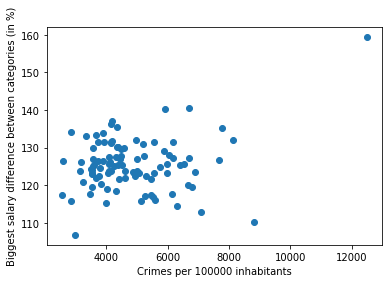

In [316]:
plt.scatter(crimesAndInequality['Crimes per 100000 inhabitants'],crimesAndInequality['Normalized Salary Difference'])
plt.xlabel("Crimes per 100000 inhabitants")
plt.ylabel("Biggest salary difference between categories (in %)")

Now, before clustering our data, let's normalize it (in the way that it is, the x-axis values are much bigger than the y-axis values, which can make the result biased). Also, we'll define the number of clusters used based on the "elbow method", where we calculate the inertia for a different number of clusters and choose as the optimal K a number located in the "elbow" of the curve (so that we have a low inertia but we have big enough clusters to analyse the clusters).

Text(0, 0.5, 'Inertia')

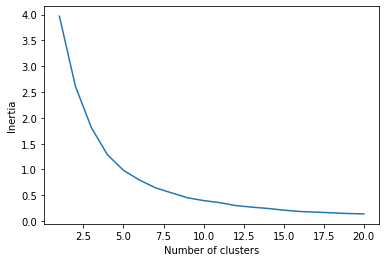

In [317]:
k = 20
inertia = []
t1 = crimesAndInequality
column1 = 'Crimes per 100000 inhabitants'
column2 =  'Normalized Salary Difference'

normalizedTable = pd.DataFrame()
crimes = np.array(t1[column1]).reshape(-1,1)
inequality = np.array(t1[column2]).reshape(-1,1)

scaler = MinMaxScaler()

normalizedTable.insert(0, "Department", t1["Department"])

scaler.fit(crimes)
normalizedTable.insert(1, "Crimes", scaler.transform(crimes))

scaler.fit(inequality)
normalizedTable.insert(2, "Inequality Coefficient", scaler.transform(inequality))

for i in range(k):
  km = KMeans(n_clusters=i+1, init='k-means++')
  km.fit(normalizedTable[['Crimes', 'Inequality Coefficient']])
  inertia.append(km.inertia_)

plt.plot(np.linspace(1,k,num=k), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

As we see above, 5 is located on the "elbow" of the curve so it shall be a good number of clusters.

In [318]:
def clusterAndCorrelation(t1, column1, column2, k):
  normalizedTable = pd.DataFrame()
  crimes = np.array(t1[column1]).reshape(-1,1)
  inequality = np.array(t1[column2]).reshape(-1,1)

  scaler = MinMaxScaler()

  normalizedTable.insert(0, "Department", t1["Department"])

  scaler.fit(crimes)
  normalizedTable.insert(1, "Crimes", scaler.transform(crimes))

  scaler.fit(inequality)
  normalizedTable.insert(2, "Inequality Coefficient", scaler.transform(inequality))

  km = KMeans(n_clusters=k, init='k-means++')
  y_predicted = km.fit_predict(normalizedTable[['Crimes', 'Inequality Coefficient']])
  
  colors = ['red', 'green', 'blue', 'yellow', 'black']

  for cluster in np.unique(y_predicted):
    plt.scatter(normalizedTable[y_predicted == cluster]['Crimes'],normalizedTable[y_predicted == cluster]['Inequality Coefficient'], color=colors[cluster])

  plt.xlabel('Crimes in the year (normalized)')
  plt.ylabel('Inequality coefficient (normalized)')

  correlation = normalizedTable['Crimes'].corr(normalizedTable['Inequality Coefficient'])
  print("Correlation between the two variables:", correlation)
  return normalizedTable


Correlation between the two variables: 0.2404842253774127


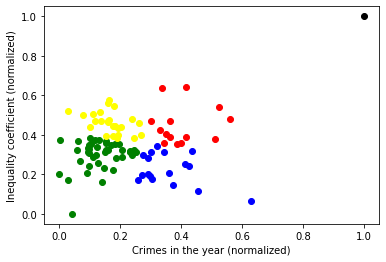

In [319]:
normalizedCrimesAndInequality = clusterAndCorrelation(crimesAndInequality, 'Crimes per 100000 inhabitants', 'Normalized Salary Difference', k=5)


In [320]:
outlier = np.argmax(crimesAndInequality['Crimes per 100000 inhabitants']);
crimesAndInequality.iloc[[outlier]]

,Department Name,Department,Crimes in 2014,Population,Crimes per 100000 inhabitants,Normalized Salary Difference
73,Paris,75,271587,2173279,12496.646772,159.349593


Correlation between the two variables: -0.01901048946940906


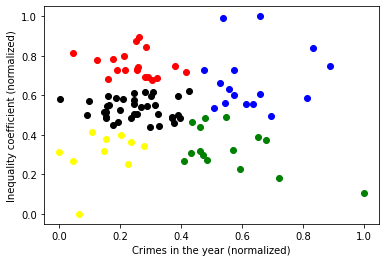

In [321]:
crimesAndInequality.drop(outlier, inplace=True);

normalizedCrimesAndInequalityWithoutOulier = clusterAndCorrelation(crimesAndInequality, 'Crimes per 100000 inhabitants', 'Normalized Salary Difference', k=5)

##Working directly with fiscal data and Gini Coefficient

Since we didn't get any great insight from this data (other than finding out that Paris is an outlier when it comes to salary discrepancy and crimes committed), we searched for data that took more than just salary difference as a measure of inequality.

We were able to find a 2015 [database](https://www.insee.fr/fr/statistiques/3560118) provided by INSEE (Institut National de la Statistique et des Études Économiques) with fiscal data by department that includes the Gini Coefficient for each department, a well-known inequality metric.

We had to download as well a [table](https://www.insee.fr/fr/statistiques/3545833?sommaire=3292701) with population data by department for the year of 2015, also provided by INSEE.

In [322]:
population2015 = pd.read_excel(io="./population2015.xls", sheet_name="Départements", skiprows=7)[["Code département", "Population totale"]]
population2015.rename(columns={"Code département": "Department", "Population totale":"Population"}, inplace=True)

crimeData2015 = df[['Department Name', 'Department', '2015']]
crimeData2015 = pd.merge(crimeData2015, population2015, on="Department")
crimeData2015['Crimes per 100000 inhabitants'] = crimeData2015['2015']/crimeData2015['Population'] * 100000
crimeData2015.rename(columns={"2015": "Crimes in 2015"}, inplace=True)
crimeData2015.head()

,Department Name,Department,Crimes in 2015,Population,Crimes per 100000 inhabitants
0,Ain,01,25761,649012,3969.264051
1,Aisne,02,23465,552529,4246.835913
2,Allier,03,12181,351626,3464.192068
3,Alpes-de-Haute-Provence,04,7996,166635,4798.511717
4,Alpes-Maritimes,06,80490,1097556,7333.566579


In [323]:
fiscalData2015 = pd.read_excel(io="./FILO_DEC_DEP.xls", sheet_name="ENSEMBLE", skiprows=5)
fiscalData2015.rename(columns={"CODGEO": "Department"}, inplace=True)
fiscalData2015.head()
crimesAndInequality = pd.merge(crimeData2015, fiscalData2015, on="Department")


In [324]:
crimesAndInequality.head()

,Department Name,Department,Crimes in 2015,Population,Crimes per 100000 inhabitants,LIBGEO,NBMEN15,NBPERS15,NBUC15,PMIMP15,Q115,Q215,Q315,Q3_Q1,D115,D215,D315,D415,D615,D715,D815,D915,RD,S80S2015,GI15,PACT15,PTSA15,PCHO15,PBEN15,PPEN15,PAUT15
0,Ain,01,25761,649012,3969.264051,Ain,252861,616256.0,411258.90,57.5,15114,21980,30916,15802,8894,13434,16622,19354,24878,28534,33912,45002,5.059816,6.907496,0.354273,72.0,65.5,2.8,3.7,23.5,4.5
1,Aisne,02,23465,552529,4246.835913,Aisne,222379,526720.5,355691.55,47.8,11436,18104,25146,13710,5458,9714,12978,15676,20596,23466,27228,34032,6.235251,8.324442,0.353915,65.6,56.0,3.5,6.1,29.7,4.7
2,Allier,03,12181,351626,3464.192068,Allier,158224,332494.5,235863.65,48.6,12756,18806,25510,12754,6700,11174,14126,16522,21152,23858,27550,34130,5.094030,6.778097,0.329146,58.4,49.8,2.9,5.7,36.9,4.7
3,Alpes-de-Haute-Provence,04,7996,166635,4798.511717,Alpes-de-Haute-Provence,73767,159497.5,111892.85,50.2,12596,19186,26960,14364,6852,11008,14004,16664,21866,25008,29278,36396,5.311734,6.901182,0.337994,58.0,48.5,3.5,6.0,34.6,7.4
4,Alpes-Maritimes,06,80490,1097556,7333.566579,Alpes-Maritimes,517016,1115861.5,782611.55,57.8,13414,21272,31058,17644,6842,11542,15088,18208,24578,28544,34098,44342,6.480854,8.740050,0.379641,64.1,55.1,3.2,5.9,27.9,8.0


Text(0, 0.5, 'Inertia')

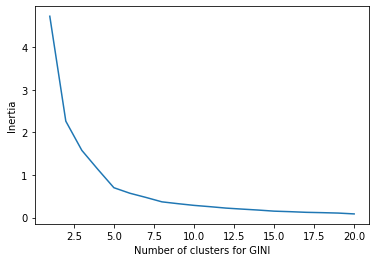

In [325]:
kgini = 20
inertiag = []
t1g = crimesAndInequality
column1g = 'Crimes per 100000 inhabitants'
column2g =  'GI15'

normalizedTableg = pd.DataFrame()
crimesg = np.array(t1g[column1g]).reshape(-1,1)
inequalityg = np.array(t1g[column2g]).reshape(-1,1)

scalerg = MinMaxScaler()

normalizedTableg.insert(0, "Department", t1g["Department"])

scalerg.fit(crimesg)
normalizedTableg.insert(1, "Crimes", scalerg.transform(crimesg))

scalerg.fit(inequalityg)
normalizedTableg.insert(2, "Inequality Coefficient", scalerg.transform(inequalityg))

for i in range(kgini):
  kmgini = KMeans(n_clusters=i+1, init='k-means++')
  kmgini.fit(normalizedTableg[['Crimes', 'Inequality Coefficient']])
  inertiag.append(kmgini.inertia_)

plt.plot(np.linspace(1,kgini,num=kgini), inertiag)
plt.xlabel('Number of clusters for GINI')
plt.ylabel('Inertia')

Correlation between the two variables: 0.6517325340531195


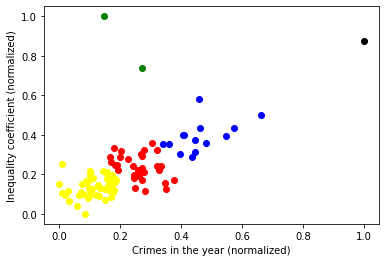

In [326]:
normalizedCrimesAndInequality = clusterAndCorrelation(crimesAndInequality, 'Crimes per 100000 inhabitants', 'GI15', k=5)

In [327]:
crimesAndInequality[["Department Name", "Department", "Crimes per 100000 inhabitants", "GI15"]].head()

,Department Name,Department,Crimes per 100000 inhabitants,GI15
0,Ain,01,3969.264051,0.354273
1,Aisne,02,4246.835913,0.353915
2,Allier,03,3464.192068,0.329146
3,Alpes-de-Haute-Provence,04,4798.511717,0.337994
4,Alpes-Maritimes,06,7333.566579,0.379641


In [328]:
crimes = np.array(crimesAndInequality['Crimes per 100000 inhabitants']).reshape(-1,1)
inequality = np.array(crimesAndInequality['GI15']).reshape(-1,1)

crimesOutlierThreshold = crimes.mean() + 3*crimes.std()
print("Crimes outlier threshold:", crimesOutlierThreshold)
crimesAndInequality[crimesAndInequality["Crimes per 100000 inhabitants"] > crimesOutlierThreshold]

Crimes outlier threshold: 8618.152657477815


,Department Name,Department,Crimes in 2015,Population,Crimes per 100000 inhabitants,LIBGEO,NBMEN15,NBPERS15,NBUC15,PMIMP15,Q115,Q215,Q315,Q3_Q1,D115,D215,D315,D415,D615,D715,D815,D915,RD,S80S2015,GI15,PACT15,PTSA15,PCHO15,PBEN15,PPEN15,PAUT15
71,Paris,75,252891,2228409,11348.500208,Paris,1032956,2099679.0,1.503225e+06,70.2,14328,27856,46384,32056,6606,11702,16992,22352,33962,41542,52450,74172,11.227975,16.928462,0.492794,72.6,62.7,2.7,7.3,17.3,10.1


In [329]:
giniOutlierThreshold = inequality.mean() + 3*inequality.std()
print("Gini outlier threshold:", giniOutlierThreshold)
crimesAndInequality[crimesAndInequality["GI15"] > giniOutlierThreshold]

Gini outlier threshold: 0.4514739734158765


,Department Name,Department,Crimes in 2015,Population,Crimes per 100000 inhabitants,LIBGEO,NBMEN15,NBPERS15,NBUC15,PMIMP15,Q115,Q215,Q315,Q3_Q1,D115,D215,D315,D415,D615,D715,D815,D915,RD,S80S2015,GI15,PACT15,PTSA15,PCHO15,PBEN15,PPEN15,PAUT15
49,La Réunion,974,32503,860896,3775.485076,La Réunion,301552,847403.5,5.362452e+05,29.7,4572,11802,22476,17904,0,3072,5970,8800,15290,19670,25924,36810,NaN,66.989249,0.521701,78.2,64.6,5.3,8.3,16.1,5.7
61,Martinique,972,18946,386875,4897.189015,Martinique,149870,351101.0,2.389714e+05,35.2,7182,15180,25450,18268,1200,5524,8784,11916,18636,22896,28560,38194,31.828333,24.671343,0.460245,72.9,63.6,3.8,5.4,23.1,4.0
71,Paris,75,252891,2228409,11348.500208,Paris,1032956,2099679.0,1.503225e+06,70.2,14328,27856,46384,32056,6606,11702,16992,22352,33962,41542,52450,74172,11.227975,16.928462,0.492794,72.6,62.7,2.7,7.3,17.3,10.1


Correlation between the two variables: 0.7777814280492167


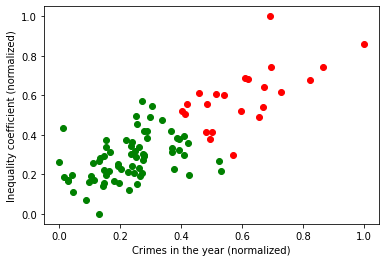

In [330]:
crimesAndInequalityWithoutOutliers = crimesAndInequality.drop([49, 61, 71])
normalizedCrimesAndInequalityWithoutOutliers = clusterAndCorrelation(crimesAndInequalityWithoutOutliers, 'Crimes per 100000 inhabitants', 'GI15', k=2)

Just for the sake of trying, we decided to check if there's a geographic factor on France inequality based on 3 criteria: the distance to Paris (since Paris is the capital of France and the department with biggest inequality, we wanted to check if departments nearby were more inclined to having bigger inequality), the latitude and the longitude. 

We found out that there's barely no correlation between inequality and the first two criteria, but surprisingly there's a weak correlation (r = 0.30) between the inequality and the longitude.

In [331]:
def latLongDistance(coordA, coordB):
  #Implements the Haversine formula
  latA, latB, longA, longB = np.radians([coordA[0], coordB[0], coordA[1], coordB[1]])
  latDistance = latA - latB;
  longDistance = longA - longB;
  a = np.sin(latDistance/2)**2 + np.cos(latA)*np.cos(latB)*np.sin(longDistance/2)**2
  c = 2*np.arcsin(np.sqrt(a))
  earthRadius = 6371
  return(c * earthRadius)

In [332]:
parisLat = float(coordinatesByDepartment[coordinatesByDepartment['Department'] == '75']['Latitude'])
parisLong = float(coordinatesByDepartment[coordinatesByDepartment['Department'] == '75']['Longitude'])
parisCoord = (parisLat, parisLong)

distances = []
for i in range(coordinatesByDepartment.shape[0]):
  lat = coordinatesByDepartment.iloc[i]['Latitude']
  lng = coordinatesByDepartment.iloc[i]['Longitude']
  distance = latLongDistance(parisCoord, (lat, lng))
  distances.append(distance)

normalizedCrimesAndInequality.insert(3, column="Distance to Paris", value=distances)
normalizedCrimesAndInequality = pd.merge(normalizedCrimesAndInequality, coordinatesByDepartment, on="Department")

In [333]:
correlation = normalizedCrimesAndInequality['Inequality Coefficient'].corr(normalizedCrimesAndInequality['Distance to Paris'])
print("Correlation between Gini Coefficient and Distance to Paris:", correlation)

correlation = normalizedCrimesAndInequality['Inequality Coefficient'].corr(normalizedCrimesAndInequality['Latitude'])
print("Correlation between Gini Coefficient and Latitude:", correlation)

correlation = normalizedCrimesAndInequality['Inequality Coefficient'].corr(normalizedCrimesAndInequality['Longitude'])
print("Correlation between Gini Coefficient and Longitude:", correlation)
  

Correlation between Gini Coefficient and Distance to Paris: 0.0012434365578947277
Correlation between Gini Coefficient and Latitude: 0.07343273647943609
Correlation between Gini Coefficient and Longitude: 0.2968019734369215


## Using Gini Coefficient to predict crime risk in departments

Knowing that the income inequality (measured by the Gini Coefficient) is strongly correlated with the crimes, we'll separate the french departments we analysed in 3 different classes according to their crime rate in 2015 (we'll call it low risk, medium risk, and high risk).

We'll use a naïve Bayes classifier to try and predict to which class of risk the department belongs to.

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(array([19., 37., 17., 11.,  8.,  2.,  1.,  0.,  0.,  1.]),
 array([ 2488.580626 ,  3374.5725842,  4260.5645424,  5146.5565006,
         6032.5484588,  6918.540417 ,  7804.5323752,  8690.5243334,
         9576.5162916, 10462.5082498, 11348.500208 ]),
 <a list of 10 Patch objects>)

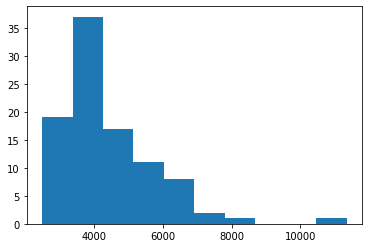

In [334]:
crimesIneqTable = crimesAndInequality[["Department", "Crimes per 100000 inhabitants", "GI15"]]
crimesIneqTable.rename(columns={"Crimes per 100000 inhabitants": "Crime Rate", "GI15": "Gini Coefficient"}, inplace=True)
plt.hist(crimesIneqTable["Crime Rate"])

In [335]:
riskClass = []
for row in range(crimesIneqTable.shape[0]):
  crimeRate = crimesIneqTable["Crime Rate"][row]
  if crimeRate < 4000:
    riskClass.append(0)
  elif crimeRate >= 4000 and crimeRate < 6000:
    riskClass.append(1)
  else:
    riskClass.append(2)

crimesIneqTable.insert(3, "Class", riskClass)
crimesIneqTable.head()

,Department,Crime Rate,Gini Coefficient,Class
0,01,3969.264051,0.354273,0
1,02,4246.835913,0.353915,1
2,03,3464.192068,0.329146,0
3,04,4798.511717,0.337994,1
4,06,7333.566579,0.379641,2


In [336]:
def predictClass(tables, test_size):
  X = np.array(crimesIneqTable[tables])
  y = np.ravel(np.array(crimesIneqTable["Class"]))

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
  X_test
  gnb = GaussianNB()
  y_pred = gnb.fit(X_train, y_train).predict(X_test)
  accuracy = metrics.accuracy_score(y_test, y_pred)
  recall = metrics.recall_score(y_test, y_pred, average=None, zero_division=1)
  if(len(recall) < 3):
    recall = np.append(recall, 0)
  return 100*accuracy, 100*recall

In [337]:
accuracyList = []
recallList = []
for i in range(1000):
  accuracy, recall = predictClass(["Gini Coefficient"], test_size=0.5)
  accuracyList.append(accuracy)
  recallList.append(recall)

accuracy = np.mean(accuracyList)
recall = np.mean(recallList, axis=0)
print("Average accuracy of the classifier:", "{:.1f}".format(accuracy), "%")
print("Accuracy for low-risk, medium-risk and high-risk classes are, respectively, ", recall[0], "%,", recall[1], "%,", recall[2], "%,")

Average accuracy of the classifier: 60.0 %
Accuracy for low-risk, medium-risk and high-risk classes are, respectively,  64.7555285571256 %, 65.17215016348335 %, 34.66404761904761 %,


## Using Gini Coefficient + Demography data to predict crime risk in departments

The Pennsylvania State University professors Jeffery Ulmer and Darrell Steffensmeier's article on "The Age and Crime Relationship" points several sources claiming a relation between crimes and age of the perpetrators:

"Today, the peak age-crime involvement (the age group with the highest age-specific arrest rate) is younger than 25 for all crimes reported in the FBI's UCR (Uniform Crime Report) program except gambling, and rates begin to decline in the late teenage years for more than half of the UCR crimes. [...]

In fact, a significant portion of U.S. national crime rate trends over time can be explained by fluctuations in the proportion of the population in the crime-prone age group of 15-to-24-years-old (Steffensmeier & Harer, 1987, 1999)."

Therefore, we decided to add demography information (the percentage of people in each department that were below, on, and above the crime-prone age group of 15-to-24-years-old) to our model and see if the accuracy of the crime-rate prediction grows.

It's important to note that we weren't able to find data on demographics for the year of 2015 (we're using 2015 data for crime rate and Gini coefficient), so we decided to use the demography information of 2014. This generates some uncertainty to our results, since the number of people from each age group defined varies from one year to the other, but we assume that this difference is small enough in one year so that we can consider the distribution roughly the same for 2014 and 2015.

In [338]:
populationAndDepartments.rename(columns={"DEP": "Department"}, inplace=True)

belowCrimeProneAge = populationAndDepartments["AGEQ80_17"] <= 15
onCrimeProneAge = np.logical_and(populationAndDepartments["AGEQ80_17"] > 15, populationAndDepartments["AGEQ80_17"] <= 30)
aboveCrimeProneAge = populationAndDepartments["AGEQ80_17"] > 30

belowCrimeProneAgeByDepartment = populationAndDepartments[belowCrimeProneAge].groupby("Department", as_index=False).sum()[["Department", "NB"]]
belowCrimeProneAgeByDepartment.rename(columns={"NB": "Below crime-prone age"}, inplace=True)
onCrimeProneAgeByDepartment = populationAndDepartments[onCrimeProneAge].groupby("Department", as_index=False).sum()[["Department", "NB"]]
onCrimeProneAgeByDepartment.rename(columns={"NB": "On crime-prone age"}, inplace=True)
aboveCrimeProneAge = populationAndDepartments[aboveCrimeProneAge].groupby("Department", as_index=False).sum()[["Department", "NB"]]
aboveCrimeProneAge.rename(columns={"NB": "Above crime-prone age"}, inplace=True)


In [339]:
crimesIneqTable = pd.merge(crimesIneqTable, belowCrimeProneAgeByDepartment, on="Department")
crimesIneqTable = pd.merge(crimesIneqTable, onCrimeProneAgeByDepartment, on="Department")
crimesIneqTable = pd.merge(crimesIneqTable, aboveCrimeProneAge, on="Department")
crimesIneqTable = pd.merge(crimesIneqTable, populationByDepartment, on="Department")

crimesIneqTable["Below crime-prone age"] = crimesIneqTable["Below crime-prone age"]/crimesIneqTable["Population"]
crimesIneqTable["On crime-prone age"] = crimesIneqTable["On crime-prone age"]/crimesIneqTable["Population"]
crimesIneqTable["Above crime-prone age"] = crimesIneqTable["Above crime-prone age"]/crimesIneqTable["Population"]

crimesIneqTable.head()

,Department,Crime Rate,Gini Coefficient,Class,Below crime-prone age,On crime-prone age,Above crime-prone age,Population
0,01,3969.264051,0.354273,0,0.267942,0.168070,0.563988,600387
1,02,4246.835913,0.353915,1,0.258206,0.167370,0.574424,514949
2,03,3464.192068,0.329146,0,0.212562,0.137852,0.649586,325421
3,04,4798.511717,0.337994,1,0.220210,0.138684,0.641106,154221
4,06,7333.566579,0.379641,2,0.215188,0.165513,0.619299,1052182


In [340]:
accuracyList = []
recallList = []
for i in range(1000):
  accuracy, recall = predictClass(["Gini Coefficient", "Below crime-prone age", "On crime-prone age", "Above crime-prone age"], test_size=0.5)
  accuracyList.append(accuracy)
  recallList.append(recall)

accuracy = np.mean(accuracyList)
recall = np.mean(recallList, axis=0)
print("Average accuracy of the classifier:", "{:.1f}".format(accuracy), "%")
print("Accuracy for low-risk, medium-risk and high-risk classes are, respectively, ", recall[0], "%,", recall[1], "%,", recall[2], "%,")

Average accuracy of the classifier: 69.0 %
Accuracy for low-risk, medium-risk and high-risk classes are, respectively,  72.04651277771853 %, 68.79883333073589 %, 63.09444444444439 %,


As we can see, the accuracy did increase from about 60% to 69%, which shows that the demography is indeed a relevant factor for determining crime rate in a given location.